# Demo of Dog ID Vision AI
- AI was built using VGG16 as feature extractor and by predicting of these features with a Random Forest and Logistic Regressor Ensemble
- Original dataset can be found here: https://www.kaggle.com/c/dog-breed-identification/data
- Full dataset was created by augmenting traing data
- Metrics: 92% accuracy score on validation set. Log loss error of 1.5 on testing set
***
## Imports and Initializations

In [28]:
#Imports
import joblib
import os
import h5py
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import random
import matplotlib.pyplot as plt
import cv2
import numpy as np

In [7]:
#Load models
log_reg = joblib.load("models/log_reg_label_encoding.pkl")
forest = joblib.load("models/xtrees_label_encoding.pkl")

In [16]:
#Get encoding for labels
augmented_paths_summary = pd.read_csv('AugmentedPaths.csv').drop(columns = ['Unnamed: 0'])
paths = list(augmented_paths_summary['path'])
random.Random(42).shuffle(paths) #Randomly shuffle our paths but use a random state to produce the same results each time
labels = [path.split(os.path.sep)[-2] for path in paths]
le = LabelEncoder()
labels = le.fit_transform(labels)

In [17]:
#Load in validation data
data = h5py.File("./FeatureWeights/VGG16_train_final.hdf5")
index = int(0.75*(len(data['labels'])))
X_val = data['features'][index:]
y_val = labels[index:]
val_paths = paths[index:]

In [38]:
#Ensembling Class
class soft_ensemble:
    
    def __init__(self, models):
        self.models = models
    
    def predict(self, X):
        #Generate a list of predictions for each model -> note each model is predicting a probability
        probabilities = np.array([model.predict_proba(X.reshape(1,-1)) for model in self.models])

        #Average the probabilities for each class
        avg_probabilities = np.average(probabilities, axis = 0)
        classification = avg_probabilities.argmax(axis = 1)
        
        return probabilities, avg_probabilities, classification

In [72]:
#Function for demo

def demo(X, y, ensemble, path, encoder):
        #Show image
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        fig = plt.figure(np.random.randint(0,1000))
        
        #Get ground truth
        ground_truth = le.inverse_transform([y])[0]
        
        #Predict with AI
        prediction = encoder.inverse_transform(ensemble.predict(X)[-1])[0]
        
        plt.title(label = "Ground Truth: {}\nAI Prediction: {}".format(ground_truth, prediction))
        plt.axis("off")
        plt.imshow(img)

In [73]:
#Initialize ensemble
ensemble = soft_ensemble([log_reg, forest])

***
## Run Demo

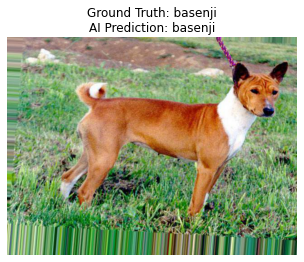

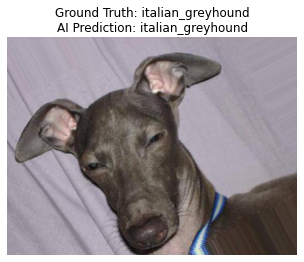

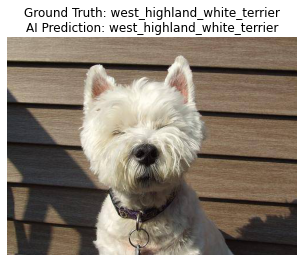

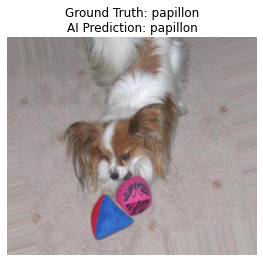

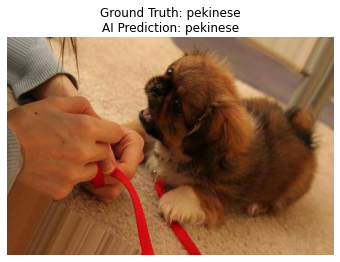

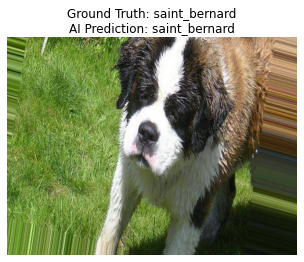

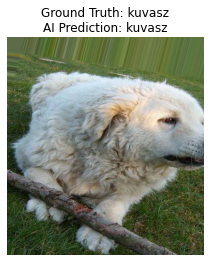

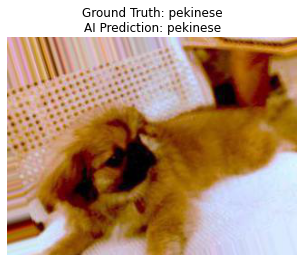

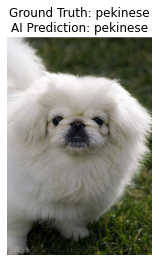

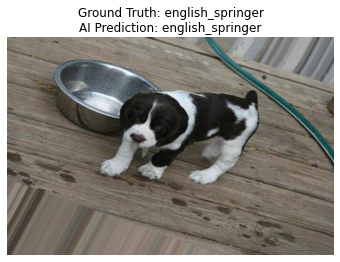

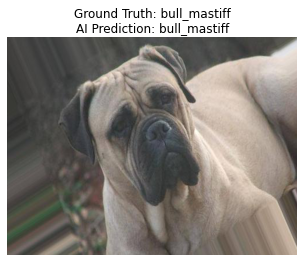

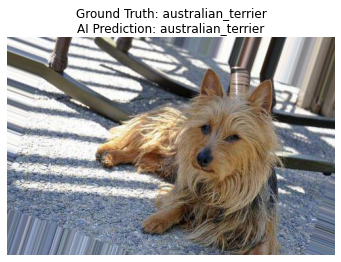

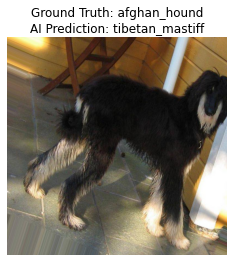

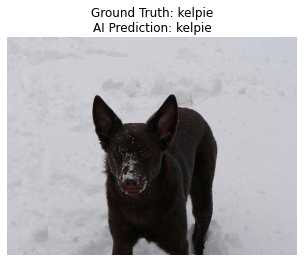

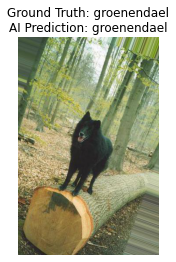

In [76]:
for X, y, path in zip(X_val[:15], y_val[:15], val_paths[:15]):
    demo(X, y, ensemble, path, le)